In [208]:
# How many rows are there in tx?

import pandas as pd
tx = pd.read_csv("../data/processed/transactions_canonical.csv", dtype="string")

In [209]:
print(len(tx))

291287


In [211]:
tx.dtypes


orderId        string[python]
shopUserId     string[python]
created        string[python]
currencyId     string[python]
orderLineId    string[python]
sku            string[python]
groupId        string[python]
quantity       string[python]
price          string[python]
name           string[python]
dtype: object

In [212]:
# Load articles
a = pd.read_csv("../data/processed/articles_clean.csv", dtype="string",
                usecols=["sku", "status", "groupId"])
a["sku"] = a["sku"].str.strip()
tx["sku"] = tx["sku"].str.strip()

# Drop existing columns so merge adds exactly one copy
tx = tx.drop(columns=["groupId", "status"], errors="ignore")

# Merge: now 'groupId' and 'status' (single copy) come from articles
tx = tx.merge(a, on="sku", how="left")

# Calculate unique skus and groupIds in tx and articles
tx_sku = pd.Index(tx["sku"].dropna().unique())
a_sku = pd.Index(a["sku"].dropna().unique())
tx_groupid = pd.Index(tx["groupId"].dropna().unique())
a_groupid = pd.Index(a["groupId"].dropna().unique())

# Calculate percentages
sku_pct = 100 * len(tx_sku.intersection(a_sku)) / len(a_sku) if len(a_sku) > 0 else float('nan')
groupid_pct = 100 * len(tx_groupid.intersection(a_groupid)) / len(a_groupid) if len(a_groupid) > 0 else float('nan')

print(f"Unique SKUs in tx: {len(tx_sku):,} | in articles: {len(a_sku):,}")
print(f"SKUs in tx as % of articles: {sku_pct:.2f}%")
print(f"Unique groupIds in tx: {len(tx_groupid):,} | in articles: {len(a_groupid):,}")
print(f"groupIds in tx as % of articles: {groupid_pct:.2f}%")

Unique SKUs in tx: 18,095 | in articles: 32,498
SKUs in tx as % of articles: 37.69%
Unique groupIds in tx: 1,127 | in articles: 1,620
groupIds in tx as % of articles: 69.57%


In [213]:
# Remove rows from tx where sku is not found in articles
tx = tx[tx["sku"].isin(a_sku)]

In [214]:
tx.sort_values("orderId", key=lambda x: x.astype(int)).head()

,orderId,shopUserId,created,currencyId,orderLineId,sku,quantity,price,name,groupId,status
291286,158790,78135,2024-05-22 14:38:29,50,454306,291294,1,11.3,Vasaravarpaan oikaisija 4/pak,291294,active
291285,158791,78136,2024-05-22 14:44:01,40,454308,542092,1,89,Tvättlappar enfärgade av frotté 5-pack,542087,active
291284,158800,78145,2024-05-22 14:54:51,40,454359,261518,1,49,Bh-förlängare 3-pack,261518,active
291272,158841,78181,2024-05-22 15:42:39,103,454625,265843-4115,1,469,Bomulls-bh uten bøyle med Magic Lift-funksjon ...,265843,active
291269,158870,78202,2024-05-22 16:18:16,134,454675,220001-0040,1,598,Jeanskjol,221416,active


In [215]:
tx.dtypes

orderId        string[python]
shopUserId     string[python]
created        string[python]
currencyId     string[python]
orderLineId    string[python]
sku            string[python]
quantity       string[python]
price          string[python]
name           string[python]
groupId        string[python]
status         string[python]
dtype: object

## Remove known bugs

In [216]:

# Remove all rows associated with shopUserId 80136 and 130244 from tx
tx = tx[~tx['shopUserId'].isin(['80136', '130244'])]

# Dedup ordrers if the same shopUserId has multiple orders (different orderId) with exactly same items (groupId) 


In [217]:
import pandas as pd

# make a day key and a stable sort so "first" is deterministic
tx["created"] = pd.to_datetime(tx["created"], errors="coerce")
tx = tx.sort_values(["shopUserId", "groupId", "created", "orderId"], na_position="last")

tx["created_date"] = tx["created"].dt.date

# keep first occurrence per key; singles are kept too
before = len(tx)
tx = tx[~tx.duplicated(subset=["shopUserId", "groupId", "created_date"], keep="first")]
after = len(tx)
print(f"Removed {before - after} duplicate rows based on shopUserId, groupId, and created_date")


Removed 13848 duplicate rows based on shopUserId, groupId, and created_date


In [218]:
# Remove rows where 'created' date is 2024-05-26, 2024-05-27, 2024-05-28, or 2024-05-29 (bugs)
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
dates_to_remove = pd.to_datetime(['2024-05-21', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29'])
tx = tx[~tx['created'].dt.normalize().isin(dates_to_remove)]

In [219]:
print(len(tx))

136917


## Unify currenies to SEK for price bucketing

In [220]:
import pandas as pd

# Hardcoded mapping (use strings to match your dtypes)
currencyid_to_country = {
    "40":  "DK",  # Danish krone
    "134": "SE",  # Swedish krona
    "103": "NO",  # Norwegian krone
    "50":  "FI",  # Finland (EUR)
}

# FX to SEK (verify/update as needed)
conversion_rates = {
    "DK": 1.494795,  # DKK -> SEK
    "NO": 0.938825,  # NOK -> SEK
    "SE": 1.0,       # SEK -> SEK
    "FI": 11.1570,   # EUR -> SEK
}

# Normalize currencyId to strings and strip
tx["currencyId"] = tx["currencyId"].astype("string").str.strip()

# Map currencyId -> country code
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)

# Map country -> SEK rate
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)

# Make sure price is numeric
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")

# Compute price in SEK, round, and convert to integer (no .0)
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(0).astype("Int64")

In [221]:
tx

,orderId,shopUserId,created,currencyId,orderLineId,sku,quantity,price,name,groupId,status,created_date,currency_country,sek_rate,price_sek
231700,290862,100102,2024-09-06 20:41:18,134,1459871,261595-4450,1,119.0,Strumpbyxa 5-p Emilia,261595,active,2024-09-06,SE,1.000000,119
172780,459823,100140,2024-12-02 18:28:53,40,2928139,261687-4090,1,379.0,Minimizer-BH Winderwire,261687,active,2024-12-02,DK,1.494795,567
285328,171345,100140,2024-06-06 19:00:43,40,526813,260451-4095,1,369.0,BH uden bøjle,264549,active,2024-06-06,DK,1.494795,552
232291,289419,100140,2024-09-05 16:58:33,40,1448423,265835-4095,1,369.0,BH uden bøjle,264549,active,2024-09-05,DK,1.494795,552
210114,334653,100140,2024-10-03 18:14:38,40,1820089,265835-4090,1,369.0,BH uden bøjle,264549,active,2024-10-03,DK,1.494795,552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275585,190671,99913,2024-06-23 10:00:55,40,672637,267831-F100,1,327.2,Sports-BH,265823,active,2024-06-23,DK,1.494795,489
265407,219152,99913,2024-07-18 10:46:05,40,910281,267831-F100,1,409.0,Sports-BH,265823,active,2024-07-18,DK,1.494795,611
238546,275857,99913,2024-08-27 11:17:51,40,1343081,267831-F100,1,409.0,Sports-BH,265823,active,2024-08-27,DK,1.494795,611
697,829619,99913,2025-09-09 11:27:08,40,5683005,291054,1,59.0,Lågåbner,291054,active,2025-09-09,DK,1.494795,88


In [222]:
# Remove rows where the price value is 6 digits
tx = tx[~tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')]

Price (SEK) statistics (up to 99th percentile):
  Count: 135,547
  Mean: 295.68
  Median: 222.00
  Std: 216.35
  Min: 0.00
  Max (99th percentile): 1,298.00


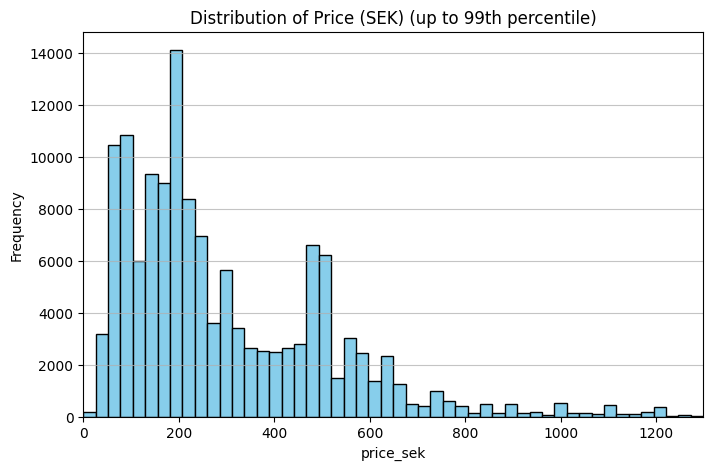

In [224]:
import matplotlib.pyplot as plt

# Show key statistics in numbers
price_sek = tx["price_sek"].dropna()
q99 = price_sek.quantile(0.99)
print("Price (SEK) statistics (up to 99th percentile):")
print(f"  Count: {price_sek[price_sek <= q99].count():,}")
print(f"  Mean: {price_sek[price_sek <= q99].mean():,.2f}")
print(f"  Median: {price_sek[price_sek <= q99].median():,.2f}")
print(f"  Std: {price_sek[price_sek <= q99].std():,.2f}")
print(f"  Min: {price_sek[price_sek <= q99].min():,.2f}")
print(f"  Max (99th percentile): {q99:,.2f}")

plt.figure(figsize=(8, 5))
plt.hist(
    price_sek[price_sek <= q99], 
    bins=50, 
    color="skyblue", 
    edgecolor="black"
)
plt.title("Distribution of Price (SEK) (up to 99th percentile)")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.xlim(price_sek[price_sek <= q99].min(), q99)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [225]:
customers = pd.read_csv("../data/processed/customers_clean.csv", dtype={"shopUserId": str})
tx = tx.drop(columns=[c for c in tx.columns if c.lower() == "age"], errors="ignore")
tx = tx.merge(customers[["shopUserId", "Age"]], on="shopUserId", how="left")

In [226]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
orderLineId         0.000000
sku                 0.000000
quantity            0.000000
price               0.000000
name                0.000000
groupId             0.000000
status              0.000000
created_date        0.000000
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000000
Age                 0.333686
dtype: float64

In [227]:
# Save cleaned transactions to CSV
tx.to_csv("../data/processed/transactions_clean.csv", index=False)

# Orders

In [228]:
tx.dtypes

orderId             string[python]
shopUserId                  object
created             datetime64[ns]
currencyId          string[python]
orderLineId         string[python]
sku                 string[python]
quantity            string[python]
price                      Float64
name                string[python]
groupId             string[python]
status              string[python]
created_date                object
currency_country            object
sek_rate                   float64
price_sek                    Int64
Age                        float64
dtype: object

In [229]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

# --- 1) Tidy dtypes (concise) ---
str_cols = ["orderId","shopUserId","currencyId","orderLineId","sku","name","groupId","status"]
tx[str_cols] = tx[str_cols].apply(lambda s: s.astype("string[python]").str.strip())

tx["created"]  = pd.to_datetime(tx["created"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").fillna(1).clip(lower=1).round().astype("Int64")
tx["price"]    = pd.to_numeric(tx["price"], errors="coerce").astype("Float64")
tx["sek_rate"] = pd.to_numeric(tx.get("sek_rate"), errors="coerce")  # float64

# Optional: price in SEK (two decimals). If you want integers, round later.
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(2)

# Line total in SEK rounded to nearest krona (integer)
tx["_line_total"] = (tx["price_sek"] * tx["quantity"]).round().astype("Int64")

# --- 2) One row per orderId ---
orders = (
    tx.sort_values(["orderId","created"])
      .groupby("orderId", as_index=False)
      .agg(
          shopUserId    = ("shopUserId", "first"),
          order_created = ("created", "min"),
          total_qty     = ("quantity", "sum"),
          basket_value  = ("_line_total", "sum"),
          currencyId    = ("currencyId", "first")
      )
)

# Ensure ints and compute avg unit price (integer)
orders["total_qty"]    = orders["total_qty"].astype(int)
orders["basket_value"] = orders["basket_value"].astype(int)
orders["avg_unit_price"] = (orders["basket_value"] / orders["total_qty"]).round().astype(int)

# --- 3) Lists per order (unique, sorted) ---
sku_list = (
    tx.groupby("orderId")["sku"]
      .apply(lambda s: sorted(pd.Series(s, dtype="string[python]").dropna().unique().tolist()))
      .rename("sku_list")
)
groupid_list = (
    tx.groupby("orderId")["groupId"]
      .apply(lambda s: sorted(pd.Series(s, dtype="string[python]").dropna().unique().tolist()))
      .rename("groupid_list")
)

orders = orders.merge(sku_list, on="orderId", how="left") \
               .merge(groupid_list, on="orderId", how="left")


In [256]:
# Number of orders
len(orders)


74870

In [304]:
orders.dtypes

orderId                    string[python]
shopUserId                 string[python]
order_created         datetime64[ns, UTC]
total_qty                           int64
basket_value                        int64
currencyId                 string[python]
avg_unit_price                      int64
sku_list                           object
groupid_list                       object
_order_date                datetime64[ns]
_groupIds_in_order                 object
groupid_tuple                      object
dtype: object

In [270]:
# Number of unique users
tx["shopUserId"].nunique()

52698

Users: 52698 | Sum of bins: 52698


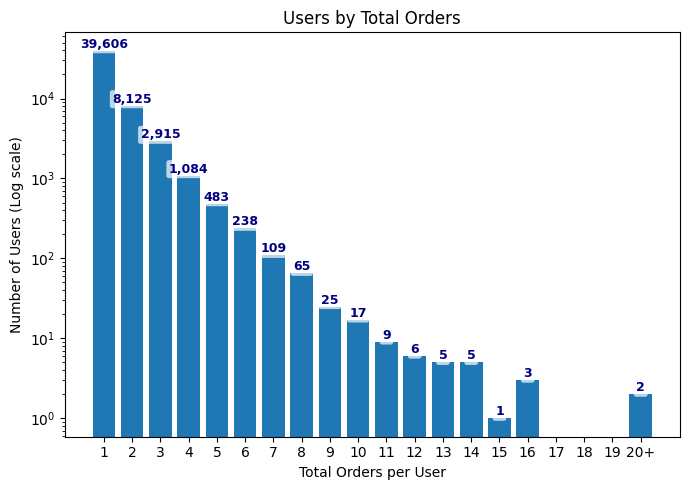

In [257]:
# total orders per user (one value per user)
n_orders_per_user = orders.groupby('shopUserId').size()

# bins: [1,2), [2,3), ..., [19,20), [20, inf)  -> label '20+' includes 20, 21, ...
bins   = list(range(1, 20)) + [20, float('inf')]
labels = [str(i) for i in range(1, 20)] + ['20+']

cats = pd.cut(n_orders_per_user, bins=bins, right=False, labels=labels, ordered=True)

# counts in the exact label order (no string sorting issues)
counts = cats.value_counts().reindex(labels, fill_value=0)

# sanity checks
assert counts.sum() == n_orders_per_user.size, "Counts should sum to #users"
print("Users:", n_orders_per_user.size, "| Sum of bins:", int(counts.sum()))

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
bars = plt.bar(labels, counts.values)
plt.yscale('log')  # optional; remember zeros won't show on log scale
plt.title('Users by Total Orders')
plt.xlabel('Total Orders per User')
plt.ylabel('Number of Users (Log scale)')

# annotate bars with more readable numbers (with thousands separator and horizontal orientation)
for i, v in enumerate(counts.values):
    if v > 0:
        plt.text(
            i, v, f'{int(v):,}', 
            ha='center', va='bottom', 
            rotation=0, fontsize=9, 
            fontweight='bold', color='navy',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2')
        )

plt.tight_layout()
plt.show()


“time to come back” (in days) between a user’s consecutive orders, buckets those gaps, and plots the distribution.

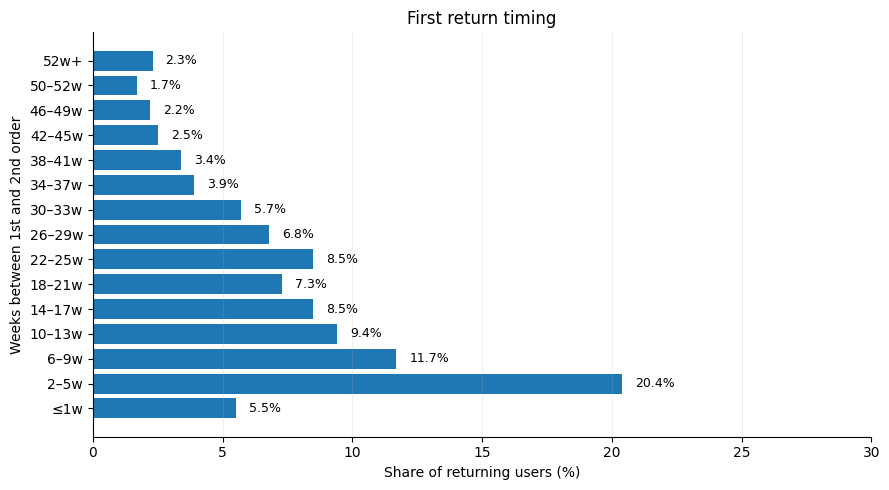

{'returning_users_denominator': 13092, 'rates_by_bucket_%': {'≤1w': 5.5, '2–5w': 20.4, '6–9w': 11.7, '10–13w': 9.4, '14–17w': 8.5, '18–21w': 7.3, '22–25w': 8.5, '26–29w': 6.8, '30–33w': 5.7, '34–37w': 3.9, '38–41w': 3.4, '42–45w': 2.5, '46–49w': 2.2, '50–52w': 1.7, '52w+': 2.3}, 'counts_by_bucket': {'≤1w': 719, '2–5w': 2677, '6–9w': 1536, '10–13w': 1232, '14–17w': 1118, '18–21w': 959, '22–25w': 1117, '26–29w': 888, '30–33w': 750, '34–37w': 510, '38–41w': 448, '42–45w': 322, '46–49w': 294, '50–52w': 223, '52w+': 299}}


In [301]:
# --- First return ONLY: weekly bins (≤1w, then 4-week bins) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

time_col = 'order_created'  # change if needed

# Prep & sort
orders[time_col] = pd.to_datetime(orders[time_col], errors='coerce', utc=True)
df = orders.dropna(subset=[time_col]).sort_values(['shopUserId', time_col]).copy()

# First return gaps (1st -> 2nd order), in WEEKS
df['next_time'] = df.groupby('shopUserId')[time_col].shift(-1)
df['gap_days']  = (df['next_time'] - df[time_col]).dt.total_seconds() / 86400.0
df['order_idx'] = df.groupby('shopUserId').cumcount()
first_ret = df.loc[df['order_idx'] == 0, ['shopUserId', 'gap_days']].dropna().copy()
first_ret = first_ret[first_ret['gap_days'] >= 0]
first_ret['gap_weeks'] = first_ret['gap_days'] / 7.0

# Bin edges in WEEKS: (0–1], (1–5], (5–9], ... up to 52, then inf
edges_w = [0, 1]
cur = 1
while cur < 52:
    cur += 4
    edges_w.append(min(cur, 52))
edges_w = sorted(set(edges_w))
if edges_w[-1] < 52:
    edges_w.append(52)
edges_w.append(np.inf)

# Labels aligned to right-closed intervals
labels = []
for a, b in zip(edges_w[:-1], edges_w[1:]):
    if np.isinf(b):
        labels.append('52w+')
    elif a == 0:
        labels.append('≤1w')
    else:
        labels.append(f'{int(a)+1}–{int(b)}w')

# Bucket (right=True → (a,b], include_lowest=True → [0,b] for first bin)
first_ret['bucket'] = pd.cut(
    first_ret['gap_weeks'],
    bins=edges_w, right=True,
    include_lowest=True,
    labels=labels, ordered=True
)

# Rates among returners (denominator = returning users only)
counts = first_ret['bucket'].value_counts().reindex(labels, fill_value=0)
total  = int(counts.sum())
rates  = (counts / total * 100).round(1) if total > 0 else counts.astype(float)

# Plot: horizontal bars (compact)
fig, ax = plt.subplots(figsize=(9,5))
ypos = np.arange(len(labels))
bars = ax.barh(labels, rates.values)

# Minimal, readable annotations (percent only)
for rect, pct in zip(bars, rates.values):
    ax.text(rect.get_width() + 0.5, rect.get_y() + rect.get_height()/2,
            f"{pct:.1f}%", va='center', ha='left', fontsize=9)

# Tidy aesthetics
ax.set_xlim(0, max(10, math.ceil((rates.max() if total>0 else 0) / 5.0) * 5 + 5))
ax.set_xlabel('Share of returning users (%)')
ax.set_ylabel('Weeks between 1st and 2nd order')
ax.set_title('First return timing')
ax.grid(axis='x', alpha=0.2)
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

print({
    "returning_users_denominator": total,
    "rates_by_bucket_%": rates.to_dict(),
    "counts_by_bucket": counts.to_dict()
})


In [280]:
# Customers who ordered once vs. more than once, and more than twice
order_counts = orders.groupby('shopUserId')['orderId'].nunique()

one_time_customers   = int((order_counts == 1).sum())
repeat_customers     = int((order_counts > 1).sum())
more_than_two_customers = int((order_counts > 3).sum())
total_customers      = int(order_counts.size)

print(f"One-time customers:      {one_time_customers:,} ({one_time_customers/total_customers*100:.1f}%)")
print(f"Repeat customers:        {repeat_customers:,} ({repeat_customers/total_customers*100:.1f}%)")
print(f"More than 3 orders:      {more_than_two_customers:,} ({more_than_two_customers/total_customers*100:.1f}%)")


One-time customers:      39,606 (75.2%)
Repeat customers:        13,092 (24.8%)
More than 3 orders:      2,052 (3.9%)


Convert transactions into orders, computing line totals, then aggregating per order to get total quantity, basket value, average unit price, and unique lists of SKUs (and product groups).

In [259]:
import pandas as pd
import numpy as np

# Start from line-level transactions
df = tx.copy()

# Ensure dtypes
df["order_created"] = pd.to_datetime(df["created"], errors="coerce")
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce").fillna(1).clip(lower=1).round().astype("Int64")
df["price"] = pd.to_numeric(df["price"], errors="coerce").astype("Float64")

# Line totals (SEK if you already converted price; else adjust)
df["_line_total"] = (df["price"] * df["quantity"]).astype("Float64")

# Helper: prefix before dash
def series_prefix_before_dash(s: pd.Series) -> list[str]:
    return s.astype("string").str.split("-", n=1).str[0].tolist()

# For list columns, keep first-seen order & drop dups
def unique_in_order(s: pd.Series) -> list:
    return list(pd.unique(s.astype("string")))

# Choose which series to use for "groupid_list"
has_groupid = "groupId" in df.columns

# Stable sort so list order is deterministic (by orderLineId if present, else sku)
sort_cols = ["orderId", "order_created"]
if "orderLineId" in df.columns:
    sort_cols.append("orderLineId")
else:
    sort_cols.append("sku")

df = df.sort_values(sort_cols)

# Aggregate to order-level
order_agg = (
    df.groupby(["orderId", "shopUserId", "order_created", "currencyId"], as_index=False)
      .agg(
          total_qty     = ("quantity", "sum"),
          basket_value  = ("_line_total", "sum"),
          sku_list      = ("sku", unique_in_order),
          groupid_list  = ( "groupId", unique_in_order ) if has_groupid
                          else ("sku", series_prefix_before_dash),
      )
)

# Average unit price (guard div-by-zero)
order_agg["avg_unit_price"] = (
    (order_agg["basket_value"] / order_agg["total_qty"].replace(0, np.nan))
    .round(2)
    .fillna(0)
)

# Reorder columns
order_agg = order_agg[
    ["orderId", "shopUserId", "order_created",
     "total_qty", "basket_value", "currencyId",
     "avg_unit_price", "sku_list", "groupid_list"]
]

print(order_agg.head(10).to_string(index=False))


orderId shopUserId       order_created  total_qty  basket_value currencyId  avg_unit_price                   sku_list     groupid_list
 158790      78135 2024-05-22 14:38:29          1          11.3         50            11.3                   [291294]         [291294]
 158791      78136 2024-05-22 14:44:01          1          89.0         40            89.0                   [542092]         [542087]
 158800      78145 2024-05-22 14:54:51          1          49.0         40            49.0                   [261518]         [261518]
 158841      78181 2024-05-22 15:42:39          1         469.0        103           469.0              [265843-4115]         [265843]
 158870      78202 2024-05-22 16:18:16          1         598.0        134           598.0              [220001-0040]         [221416]
 158877      78212 2024-05-22 16:30:05          1         179.0        134           179.0              [261324-M...]         [261324]
 158881      78216 2024-05-22 16:52:01          1      

list the top 20 repurchased products (groupId)

In [268]:
import pandas as pd
import numpy as np

# Ensure we're counting orders (not units) per (user, product)
df = (df.sort_values(["shopUserId","groupId","created","orderId"])
        .drop_duplicates(subset=["shopUserId","groupId","orderId"], keep="first"))

# Orders per user×product
pair_orders = (df.groupby(["shopUserId","groupId"])["orderId"]
                 .nunique()
                 .rename("n_orders"))

# Keep only users who bought the same product in >=3 different orders
heavy_pairs = pair_orders[pair_orders >= 3].reset_index()

# KPI per product
users_3plus = (heavy_pairs.groupby("groupId")["shopUserId"]
                          .nunique()
                          .rename("Number of repeat buyers (3+ orders)"))
unique_buyers = (df.groupby("groupId")["shopUserId"]
                   .nunique()
                   .rename("Total unique buyers"))

# Representative name per product
def rep_name(s: pd.Series):
    s = s.dropna()
    if s.empty: return pd.NA
    m = s.mode()
    return m.iat[0] if not m.empty else s.iloc[0]
name_by_group = df.groupby("groupId")["name"].apply(rep_name).rename("Product name")

# Median consecutive-gap for these heavy repeaters (if rebuy_gaps exists)
if "rebuy_gaps" in globals():
    heavy_keys = set(map(tuple, heavy_pairs[["shopUserId","groupId"]].to_numpy()))
    mask_heavy = rebuy_gaps.set_index(["shopUserId","groupId"]).index.isin(heavy_keys)
    median_gap_heavy = (rebuy_gaps[mask_heavy]
                        .groupby("groupId")["gap_days_consecutive"]
                        .median()
                        .rename("Median days between repeat purchases"))
    # Remove decimals (convert to int, but keep NaN as is)
    median_gap_heavy = median_gap_heavy.apply(lambda x: int(round(x)) if pd.notnull(x) else x)
else:
    median_gap_heavy = pd.Series(dtype=float, name="Median days between repeat purchases")

# Assemble Top 10
top10 = (users_3plus.to_frame()
         .join(unique_buyers, how="left")
         .join(name_by_group, how="left")
         .join(median_gap_heavy, how="left")
         .assign(Repeat_purchase_rate_pct=lambda d: (d["Number of repeat buyers (3+ orders)"] / d["Total unique buyers"]) * 100)
         .sort_values(["Number of repeat buyers (3+ orders)","Repeat_purchase_rate_pct"], ascending=False)
         .head(10)
         .reset_index())

# Pretty print
cols = [
    "groupId",
    "Product name",
    "Number of repeat buyers (3+ orders)",
    "Total unique buyers",
    "Median days between repeat purchases"
]
out = (top10[cols]
       .rename(columns={
           "groupId": "Product ID"
       })
)

print(out.to_string(index=False))


Product ID                      Product name  Number of repeat buyers (3+ orders)  Total unique buyers  Median days between repeat purchases
    261637                    Ankelsocka VID                                   54                 3202                                    57
    263988 Stödknästrumpor i nylon med spets                                   53                 1040                                   107
    260596               Bh utan bygel Stars                                   46                 1662                                    70
    241562                        Velourbyxa                                   38                 1766                                    53
    260646                      Trosa 3-pack                                   35                 2646                                    81
    261610    Stretchtrosa Basic Maxi 2-pack                                   29                  993                                    73
    242024   

# Sanity checks

In [242]:
# Same-user, same-day orders (calendar day) and check if those orders have the same total price
# Also, include what groupIds were in each order (from groupid_list)

import pandas as pd

# ensure datetime
orders['order_created'] = pd.to_datetime(orders['order_created'], errors='coerce')

# calendar day
orders['_order_date'] = orders['order_created'].dt.floor('D')

# For each order, collect all groupIds in that order from groupid_list
# If groupid_list is not a list, wrap it in a list
orders['_groupIds_in_order'] = orders['groupid_list'].apply(lambda x: x if isinstance(x, list) else [x])

# aggregate per (user, day)
same_day = (
    orders
    .groupby(['shopUserId', '_order_date'], as_index=False)
    .agg(
        n_orders=('orderId', 'nunique'),
        orderIds=('orderId', lambda s: sorted(s.tolist())),
        times=('order_created', lambda s: sorted(s.dt.strftime('%H:%M:%S').tolist())),
        basket_values=('basket_value', lambda s: sorted(s.tolist())),
        # For each order, collect the groupIds in that order, so we get a list of lists
        groupIds_per_order=('_groupIds_in_order', lambda s: [g for g in s])
    )
)

# keep only days with 2+ orders
same_day_multi = same_day.query('n_orders > 1').sort_values(['n_orders', '_order_date', 'shopUserId'], ascending=[False, True, True])

# Check if all basket_values are the same for each group
def all_equal(lst):
    return len(set(lst)) == 1 if len(lst) > 1 else True

same_day_multi['same_total_price'] = same_day_multi['basket_values'].apply(all_equal)

print(f"Users with multiple orders on the same day: {same_day_multi.shape[0]}")
print(
    same_day_multi[
        ['shopUserId', '_order_date', 'n_orders', 'orderIds', 'times', 'basket_values', 'groupIds_per_order', 'same_total_price']
    ].head(100).to_string(index=False)
)

Users with multiple orders on the same day: 261
shopUserId _order_date  n_orders                         orderIds                                    times         basket_values                                                           groupIds_per_order  same_total_price
    104278  2025-07-18         4 [767273, 767274, 767279, 767292] [12:23:33, 12:26:25, 12:29:09, 12:39:57] [445, 522, 595, 1415]                             [[505254], [292656], [290118, 290209], [294389]]             False
    278024  2025-08-22         4 [804740, 804775, 804829, 805001] [10:54:13, 11:22:16, 11:56:36, 13:56:18] [280, 468, 525, 1033]                                     [[265823], [242198], [250192], [240187]]             False
    638761  2025-02-13         3         [582552, 582682, 583240]           [11:42:02, 12:57:28, 19:59:09]       [140, 328, 440]                                               [[221416], [261938], [241687]]             False
    254650  2025-08-22         3         [804464, 804616